In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
## Constants

service_times = {
    "contract"  :   30,
    "complain"  :   25,
    "confirm"   :   10,
    "request"   :   5, 
    "review"    :   10,
}

transition_matrices = {
    "A" : {
        "services": ["complain", "contract"], 
        "matrix" : [
            [0.9, 0.1], [0.2, 0.8],
        ],
        "time_between": 5
    },
    "B" : {
        "services": ["review", "request"], 
        "matrix" : [
            [0.95, 0.05], [0.15, 0.85],
        ],
        "time_between": 7
    },
    "C" : {
        "services": ["review", "request", "confirm"], 
        "matrix" : [
            [0.75, 0.15, 0.1], [0.1, 0.8, 0.1], [0.05, 0.05, 0.9],
        ],
        "time_between": 10
    },
}

interarrival_times = {
    "contract"  :   ["minute", "normal", 40, 36],
    "complain"  :   ["hour", "exponential", 0.5],
    "confirm"   :   ["hour", "gamma", 1, 2],
    "request"   :   ["minute", "exponential", 0.06], 
    "review"    :   ["minute", "normal", 15, 36],
}

queue_policies = {
    "contract"  :   'spt',
    "complain"  :   'fifo',
    "confirm"   :   'fifo',
    "request"   :   'spt',
    "review"    :   'siro',
}



In [3]:
class ServiceType:
    def __init__(self, name):
        self.name = name
        self.service_time = service_times[name]
        self.queue_policy = queue_policies[name]

    def get_service_time(self):
        scale = self.service_time
        sample = math.ceil(np.random.exponential(scale=scale))
        # print(scale, sample)
        return sample 
    
    def get_interarrival_time(self): 
        config = interarrival_times[self.name]
        scale, distr, params = config[0], config[1], config[2:]
        sample = 0
        if distr == "normal": 
            sample = np.random.normal(loc=params[0], scale=params[1]**0.5)
        elif distr == "exponential": 
            sample = np.random.exponential(scale=1/params[0])
        elif distr == "gamma": 
            sample = np.random.gamma(scale=1/(2*params[0]), shape=params[1])
        
        if scale == "hour": 
            sample *= 60
        elif scale == "second": 
            sample /= 60 
        
        return math.ceil(sample)        

class WorkerType: 
    def __init__(self, name):
        self.name = name
        config = transition_matrices[name]
        self.trans_dict = {}
        services = config["services"]
        for i in range(len(services)) :
            self.trans_dict[services[i]] = config["matrix"][i]
        self.transition_time = config["time_between"]
    
    def get_first_job(self): 
        # print(self.trans_dict.keys().)
        job_name = np.random.choice(list(self.trans_dict.keys()))
        return job_name
    
    def get_next_job(self, job): 
        next_job = np.random.choice(list(self.trans_dict.keys()), p=self.trans_dict[job])
        if next_job == job: 
            return None 
        return next_job
    
    def get_jobs(self):
        return list(self.trans_dict.keys())
          
class Worker: 
    def __init__(self, type: WorkerType):
        self.type = type
        self.current_job = type.get_first_job()
        self.current_customer = None 
        self.time_to_move = type.transition_time
        self.works_on_jobs = {}
        for job in type.get_jobs():
            self.works_on_jobs[job] = 0

    
    def customer_finished(self, i): 
        if self.current_customer: 
            self.current_customer.proceed_work(i)
            if self.current_customer.is_finished(): 
                self.current_customer = None 
                return True 
        return False

    def maybe_move(self): 
        self.time_to_move -= 1
        if self.time_to_move == 0: 
            self.time_to_move = self.type.transition_time
            next_job = self.type.get_next_job(self.current_job)
            if next_job: 
                # print(f"worker moved: {self.current_job} -> {next_job}")
                customer = self.current_customer
                self.current_customer = None 
                self.current_job = next_job
                return customer
    
    def needs_customer(self): 
        if self.current_customer != None: 
            self.works_on_jobs[self.current_job] += 1
            return False 
        return self.current_job
    
    def take_customer(self, customer): 
        self.current_customer = customer
        # print(str(self))
            
    def __str__(self): 
        return f"{self.type.name}:{self.current_job} => {self.current_customer}"



class Customer: 
    def __init__(self, type: ServiceType, enter_time): 
        self.type = type 
        self.enter_time = enter_time
        self.service_time = type.get_service_time()
        # print(f"new_customer: {type.name}, {self.service_time}")
        self.remainig_time = self.service_time
        self.finish_time = -1

    def is_finished(self): 
        return self.remainig_time == 0
    
    def proceed_work(self, i): 
        self.remainig_time -= 1
        if self.is_finished():
            self.finish_time = i
            # print(f"customer_finished: {self.type.name}, {self.enter_time}-{self.finish_time}")

    def __str__(self): 
        return f"{self.type.name}"



class Service: 
    def __init__(self, type: ServiceType):
        self.type = type 
        self.queue = []
        self.customers = []
        self.next_customer = self.type.get_interarrival_time()
        while(self.next_customer <= 0): # checks that normal dist does not return negative
            self.next_customer = self.type.get_interarrival_time()
        self.working_customers = 0
        self.A = [self.next_customer]
        self.L_Q = []
        self.L = []

    def customer_arrived(self, i): 
        self.L_Q.append(len(self.queue))
        # self.L.append(self.L_Q[-1] + self.working_customers)
        active_customer = len(self.customers)
        for customer in self.customers:
            if customer.is_finished():
                active_customer -= 1
        self.L.append(active_customer)
        self.next_customer -= 1
        if self.next_customer == 0: 
            self.next_customer = self.type.get_interarrival_time()
            while(self.next_customer <= 0): # checks that normal dist does not return negative
                self.next_customer = self.type.get_interarrival_time()
            self.A.append(self.next_customer)
            customer = Customer(self.type, i)
            self.customers.append(customer)
            self.enqueue(customer)
    
    def enqueue(self, customer): 
        self.queue.append(customer)

    def dequeue(self): 
        if len(self.queue) == 0: 
            return None 
        policy = self.type.queue_policy
        if policy == 'fifo': 
            return self.queue.pop(0)
        elif policy == 'spt': 
            self.queue.sort(key=lambda x: x.remainig_time)
            return self.queue.pop(0)
        elif policy == 'siro': 
            return self.queue.pop(np.random.randint(0, len(self.queue)))
        
    def get_service_times(self): 
        s = [c.service_time - c.remainig_time for c in self.customers]
        return s
    
    def finish(self, i): 
        for customer in self.customers: 
            if customer.finish_time == -1: 
                customer.finish_time = i
                # print(f"customer_not_finished: {customer.type.name}, {customer.enter_time}-{customer.finish_time}")

    def get_w_times(self): 
        w = [c.finish_time - c.enter_time for c in self.customers]
        return w




        

In [4]:
def simulate(workers_count, simulation_time):

    services = {}
    workers = []

    for name in service_times: 
        service_type = ServiceType(name)
        service = Service(service_type)
        services[name] = service

    for job in transition_matrices: 
        worker_type = WorkerType(job)
        for i in range(workers_count): 
            w = Worker(worker_type)
            workers.append(w)

    for i in range(simulation_time): # each iteratnio is 1 minute
        # print(f"============= {i} ===============")
        # print([str(worker) for worker in workers])
        
        # add new customers 
        for service in services.values():
            service.customer_arrived(i)

        # remove finished customers
        for worker in workers: 
            if worker.customer_finished(i):
                services[worker.current_job].working_customers -= 1

        # move workers
        for worker in workers: 
            customer = worker.maybe_move()
            if customer: 
                services[customer.type.name].enqueue(customer)

        # update queues
        for worker in workers: 
            job = worker.needs_customer()
            if job: 
                customer = services[job].dequeue()
                # print(customer)
                if customer: 
                    worker.take_customer(customer)
                    services[job].working_customers += 1

    for service in services:
        services[service].finish(i)

    return services, workers
                






In [5]:
services, workers = simulate(2, 480)
A = {}
S = {}
W = {}
W_Q = {}
L = {}
L_Q = {}

workers_times = [worker.works_on_jobs for worker in workers]

for service in services: 
    A[service] = services[service].A
    S[service] = services[service].get_service_times()
    W[service] = services[service].get_w_times()
    W_Q[service] = [W[service][i] - S[service][i] for i in range(len(S[service]))]
    L[service] = services[service].L
    L_Q[service] = services[service].L_Q



print(A)
print(S)
print(W)
print(W_Q)
print(L)
print(L_Q)

print(workers_times)

{'contract': [45, 46, 42, 38, 41, 43, 44, 40, 33, 39, 37, 45], 'complain': [39, 53, 26, 69, 209, 124], 'confirm': [84, 38, 130, 10, 44, 22, 13, 62, 155], 'request': [24, 21, 17, 6, 28, 5, 3, 2, 23, 23, 15, 85, 15, 25, 1, 6, 3, 8, 11, 10, 8, 50, 11, 19, 56, 2, 15], 'review': [18, 13, 12, 9, 17, 8, 7, 15, 10, 6, 13, 16, 19, 26, 28, 15, 12, 11, 11, 12, 19, 23, 14, 23, 19, 11, 14, 8, 16, 14, 18, 23, 21]}
{'contract': [32, 39, 37, 7, 13, 29, 8, 36, 0, 18, 2], 'complain': [12, 17, 4, 6, 5], 'confirm': [12, 4, 10, 2, 17, 15, 20, 4], 'request': [3, 9, 2, 4, 1, 8, 1, 2, 20, 2, 10, 3, 1, 9, 1, 6, 10, 5, 7, 4, 5, 5, 9, 1, 5, 1], 'review': [18, 1, 1, 36, 9, 16, 6, 2, 13, 1, 5, 2, 12, 2, 24, 3, 3, 1, 2, 1, 4, 1, 5, 9, 16, 6, 5, 13, 11, 7, 23, 0]}
{'contract': [37, 83, 113, 10, 21, 74, 9, 141, 108, 69, 29], 'complain': [12, 17, 4, 6, 5], 'confirm': [28, 4, 88, 80, 53, 46, 53, 4], 'request': [3, 9, 2, 41, 10, 17, 3, 5, 20, 2, 10, 11, 1, 9, 1, 6, 10, 5, 7, 4, 5, 5, 9, 1, 5, 1], 'review': [18, 1, 1, 36

---------------------------------------------------

In [46]:
def draw_line_chart(x, y, title:str, label_x:str=None, label_y:str=None, sorted: bool=False, fig_size: tuple=None, annotation_mode: str=None):
    if fig_size:
        plt.figure(figsize=fig_size)
    if sorted:
        y = y.copy()
        y.sort()
    plt.plot(x, y, marker='o', linestyle='-')
    
    if annotation_mode:
        if annotation_mode == 'both':
            for i, (xi, yi) in enumerate(zip(x, y)):
                plt.annotate(f'({xi}, {yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')
        elif annotation_mode == 'single':
            for i, (xi, yi) in enumerate(zip(x, y)):
                plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')
    
    plt.grid(True)
    plt.title(title)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    # plt.show()


# Contract Service

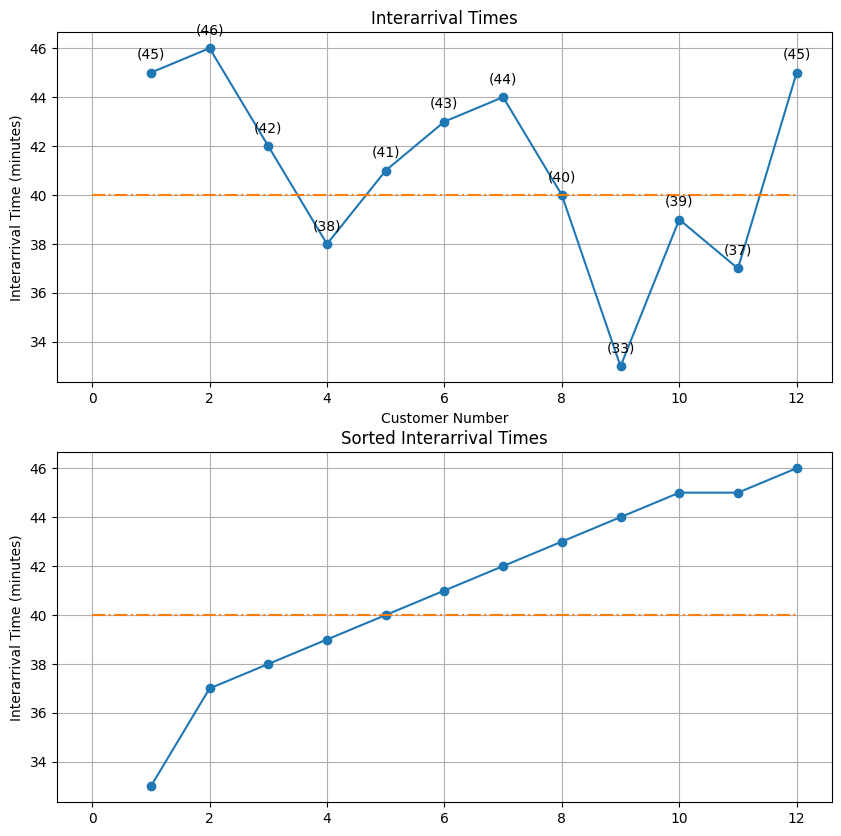

In [7]:
# Plotting Interarrival Times of Contract Customers (A_n)
x = list(range(1,len(A["contract"])+1))

# draw_line_chart(x, A['contract'], title="Interarrival Times", label_x="Customer Number", label_y="Interarrival Time (minutes)", fig_size=(15,10), annotation_mode='single')
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(x, A["contract"], label="Interarrival Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, A["contract"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.plot([0, max(x)], [40,40], linestyle='-.')
plt.grid(True)
plt.title("Interarrival Times")
plt.xlabel("Customer Number")
plt.ylabel("Interarrival Time (minutes)")

plt.subplot(212)
y = A['contract'].copy()
y.sort()
plt.plot(x, y, marker='o', linestyle='-')
plt.plot([0, max(x)], [40,40], linestyle='-.')
plt.grid(True)
plt.title("Sorted Interarrival Times")
plt.ylabel("Interarrival Time (minutes)")
plt.show()




As Expected the time intervals between arrival of two consecutive customers is centered around 40, since it follows normal distribution with with mean 40.

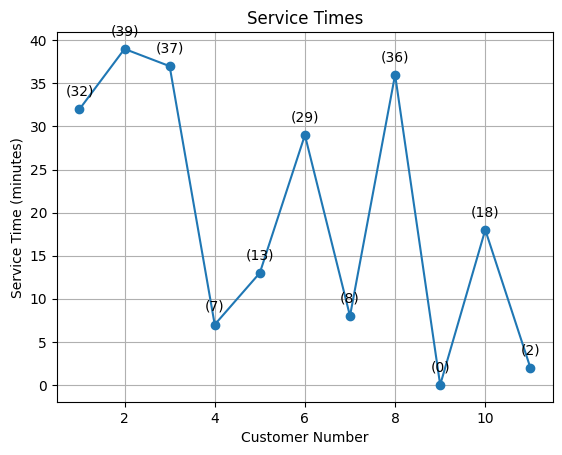

In [8]:
# Plotting Service Times of Contract Customers (S_n)
x = list(range(1,len(S["contract"])+1))
# plt.figure(figsize=(15, 10))
plt.plot(x, S["contract"], label="Service Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, S["contract"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Service Times")
plt.xlabel("Customer Number")
plt.ylabel("Service Time (minutes)")
plt.show()


Note: service Time 0 mean that the customer didn't get any service in simulation period.

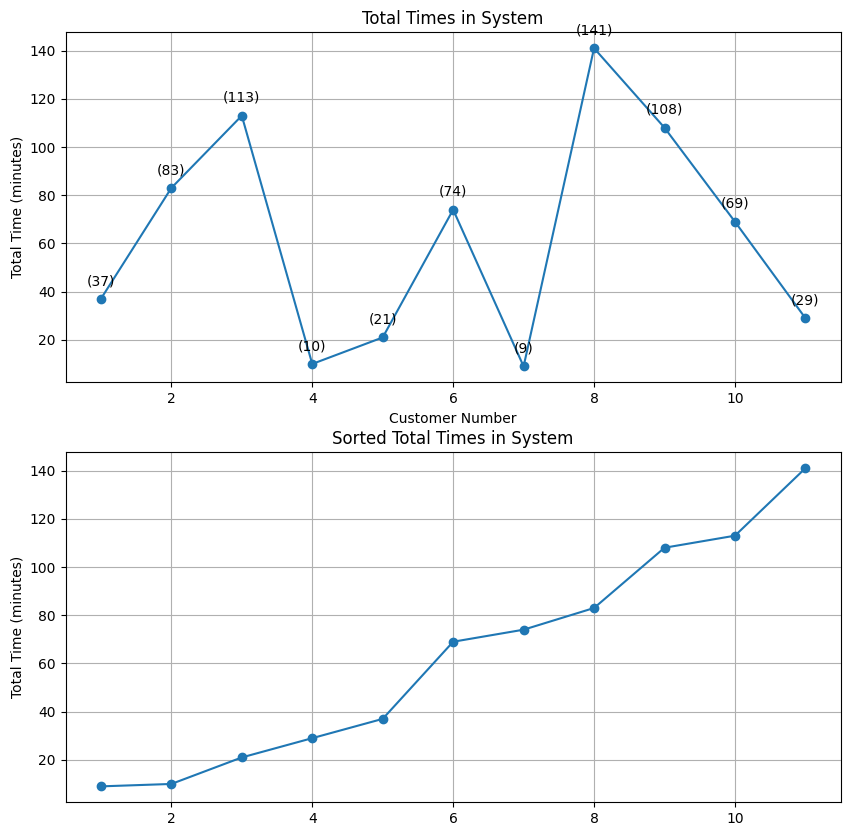

In [48]:
# Plotting Total Time each Contract Customer Spends in the System (W_n)
x = list(range(1,len(W["contract"])+1))
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(x, W["contract"], label="Total Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, W["contract"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Times in System")
plt.xlabel("Customer Number")
plt.ylabel("Total Time (minutes)")

plt.subplot(212)
draw_line_chart(x, W['contract'], title="Sorted Total Times in System", label_y="Total Time (minutes)", sorted=True)

plt.show()

Total time that a customer is in the system is the sum of the time it is being serviced, plus the time it waits in queue.

An intersting fact about the graph abvoe, is that the first customer has waited 5 minutes(considering its service time is 32) which is due to the fact that there where no workers as this job from the time that customer 1 has arrived until 5 minutes later.

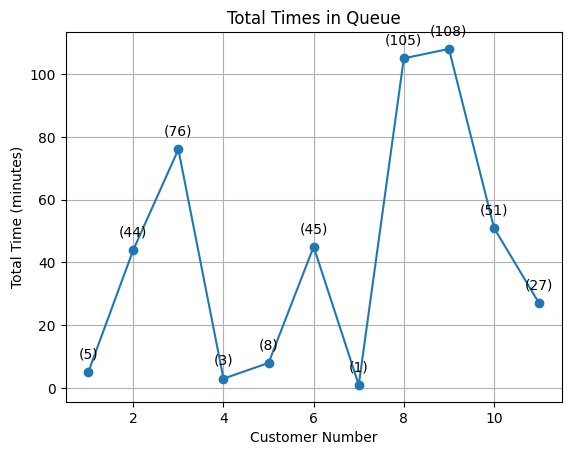

In [10]:
# Plotting Total Time each Contract Customer Spends in the Queue (W_Qn)
x = list(range(1,len(W_Q["contract"])+1))
# plt.figure(figsize=(15, 10))
plt.plot(x, W_Q["contract"], label="Total Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, W_Q["contract"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Times in Queue")
plt.xlabel("Customer Number")
plt.ylabel("Total Time (minutes)")
plt.show()


As mentioned above total time in queue is the total time in system minus the time being serviced.

now one interesting fact about the above graph is that its shape is similar to "Total Time in System" graph; this is due to the fact that waiting time (time in queue) has some bigger numers compared to its service time, so the addition of service time doesn't realy change the pivotal points of graph.

In [49]:
for x in services['contract'].customers:
    print(x.service_time)

32
39
37
7
13
29
8
79
35
21
2


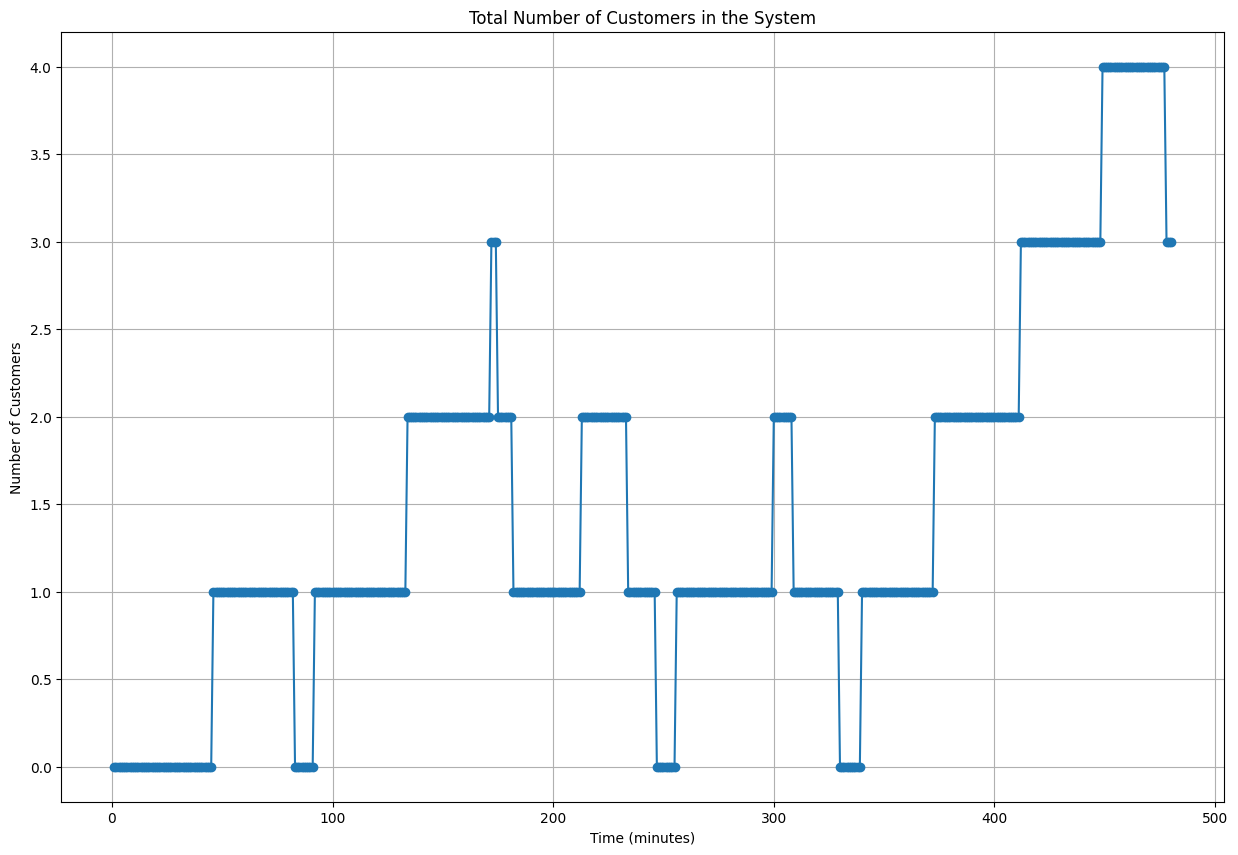

In [11]:
# Plotting Total Number of Customers in the System (L_n)
x = list(range(1,len(L["contract"])+1))
plt.figure(figsize=(15, 10))
plt.plot(x, L["contract"], label="Total Times", marker='o', linestyle='-')

# for i, (xi, yi) in enumerate(zip(x, L["contract"])):
    # plt.annotate(f'({xi}, {yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Number of Customers in the System")
plt.xlabel("Time (minutes)")
plt.ylabel("Number of Customers") 
plt.show()


The $L_t$ Graph show the number of customers in the system at every minute during simulation period.

Now cosindering the interarrival times, we know that customer 1 has arrived at minute 45 and customer 2 at minute 91, now since customer 1 has 32 minutes service time, there is an interval between minute 77 til 91 (not necessarily equal to this interval) where customer 1 is done and has left the system and customer 2 hasn't arrived, this is the inteval in the graph where we have 0 customer in this system.

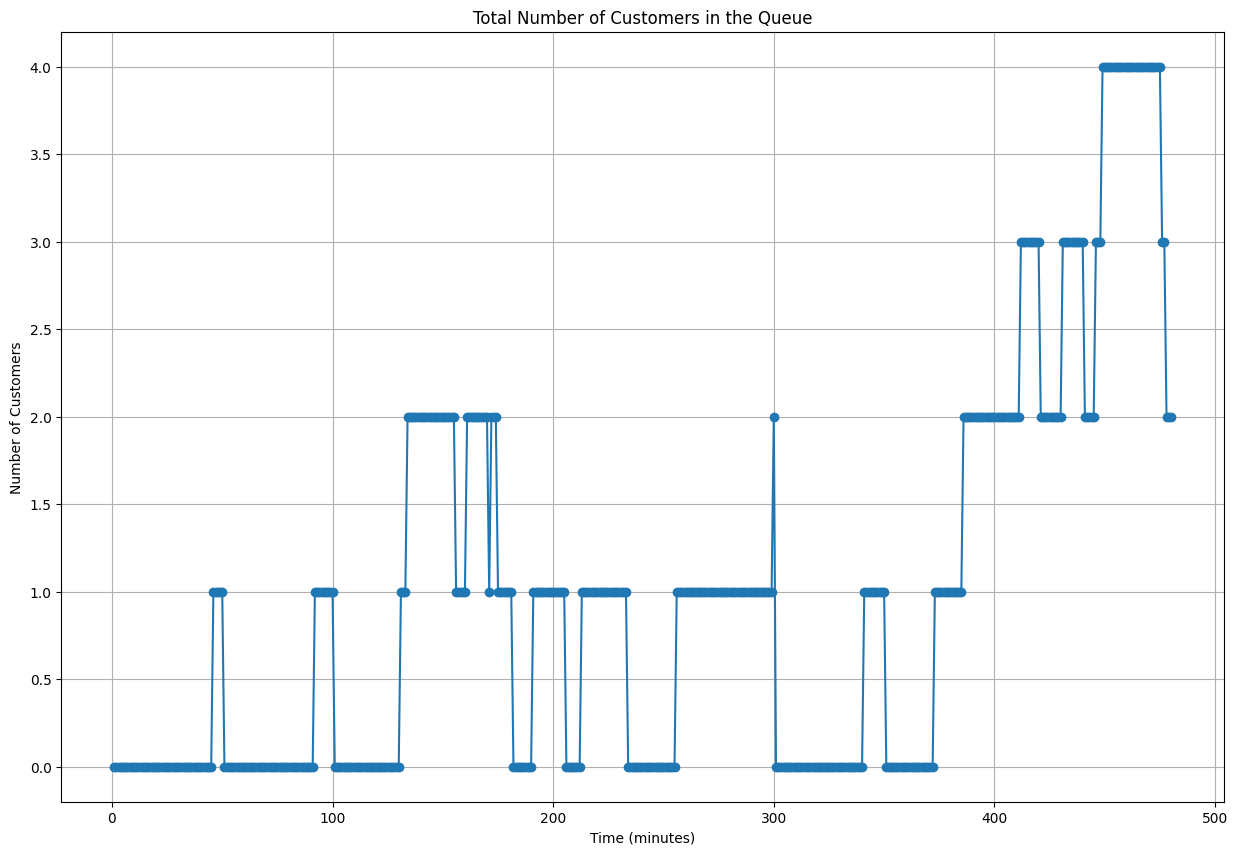

In [12]:
# Plotting Total Number of Customers in the Queue at Time n (L_Qn)
x = list(range(1,len(L_Q["contract"])+1))
plt.figure(figsize=(15, 10))
plt.plot(x, L_Q["contract"], label="Total Times", marker='o', linestyle='-')

# for i, (xi, yi) in enumerate(zip(x, L_Q["contract"])):
    # plt.annotate(f'({xi}, {yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Number of Customers in the Queue")
plt.xlabel("Time (minutes)")
plt.ylabel("Number of Customers")
plt.show()

The graph $L_t^Q$ shows exactly how many people are in queue at every minute of simulation.
we can visualy see the 5 minutes customer 1 has waited in the system; from minute 45 when customer 1 has arrived, it goes to queue since there are no workers for this type of job; we can see that the same scenario is also true for customer 2 since when it arrives, customer 1 has already left the system, but customer 2 goes to queue never the less

In [13]:
# Calculate the average number of customers in the system(L) and in the queue(L_Q), 
# and the average time spent in the system(W) and in the queue(W_Q) for each service type.

# Average Number of Customers in the System (L)
L_avg = np.mean(L["contract"])
print(f"Average Number of Customers in the System (L): {L_avg}")

# Average Number of Customers in the Queue (L_Q)
L_Q_avg = np.mean(L_Q["contract"])
print(f"Average Number of Customers in the Queue (L_Q): {L_Q_avg}")

# Average Time Spent in the System (W)
W_avg = np.mean(W["contract"])
print(f"Average Time Spent in the System (W): {W_avg}")

# Average Time Spent in the Queue (W_Q)
W_Q_avg = np.mean(W_Q["contract"])
print(f"Average Time Spent in the Queue (W_Q): {W_Q_avg}")



Average Number of Customers in the System (L): 1.4458333333333333
Average Number of Customers in the Queue (L_Q): 0.9854166666666667
Average Time Spent in the System (W): 63.09090909090909
Average Time Spent in the Queue (W_Q): 43.0


# Complain Service

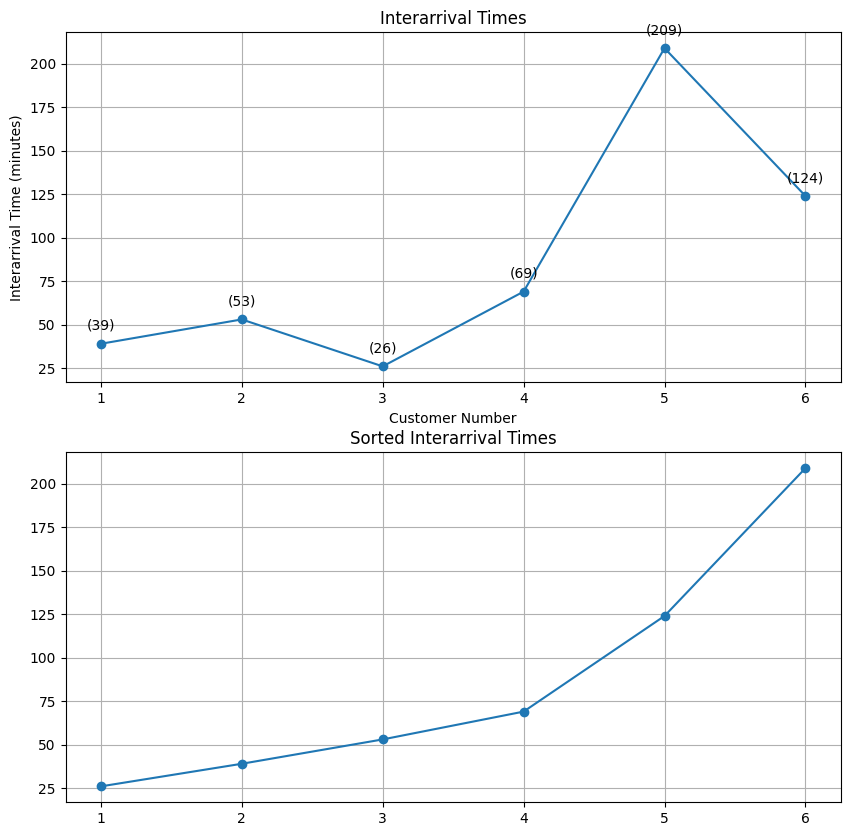

In [50]:
# Plotting Interarrival Times of Complain Customers (A_n)
x = list(range(1,len(A["complain"])+1))
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(x, A["complain"], label="Interarrival Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, A["complain"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Interarrival Times")
plt.xlabel("Customer Number")
plt.ylabel("Interarrival Time (minutes)")

plt.subplot(212)
draw_line_chart(x, A['complain'], title="Sorted Interarrival Times", sorted=True)

plt.show()


Arrival Time intervals follow exponential distribution with mean 120 minutes, as we can see in above graph.

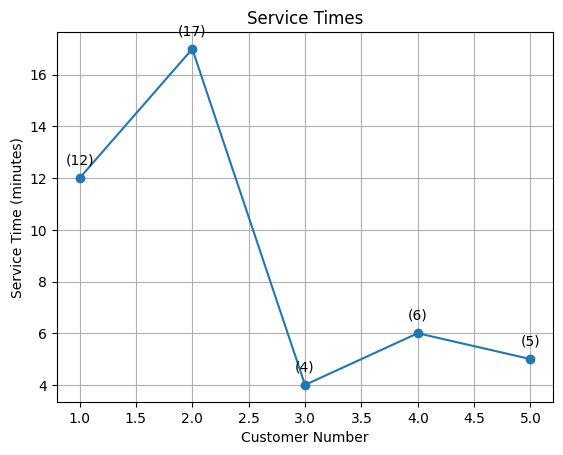

In [15]:
# Plotting Service Times of Complain Customers (S_n)
x = list(range(1,len(S["complain"])+1))
# plt.figure(figsize=(15, 10))
plt.plot(x, S["complain"], label="Service Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, S["complain"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Service Times")
plt.xlabel("Customer Number")
plt.ylabel("Service Time (minutes)")
plt.show()

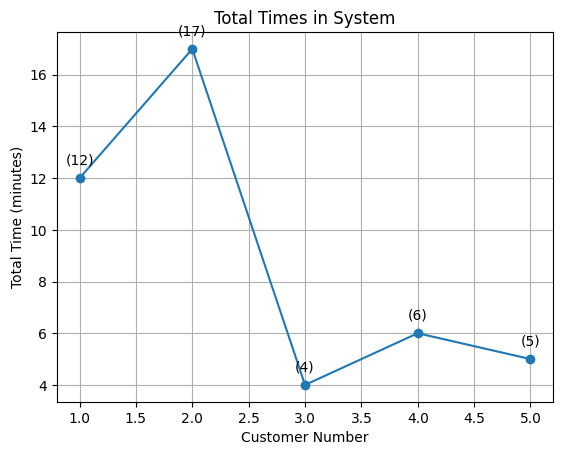

In [16]:
# Plotting Total Time each Complain Customer Spends in the System (W_n)
x = list(range(1,len(W["complain"])+1))
# plt.figure(figsize=(15, 10))
plt.plot(x, W["complain"], label="Total Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, W["complain"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Times in System")
plt.xlabel("Customer Number")
plt.ylabel("Total Time (minutes)")
plt.show()

As we can see the $W_n$ graph is identical to "Service Time" graph which means no customer in this system have waited in a queue.

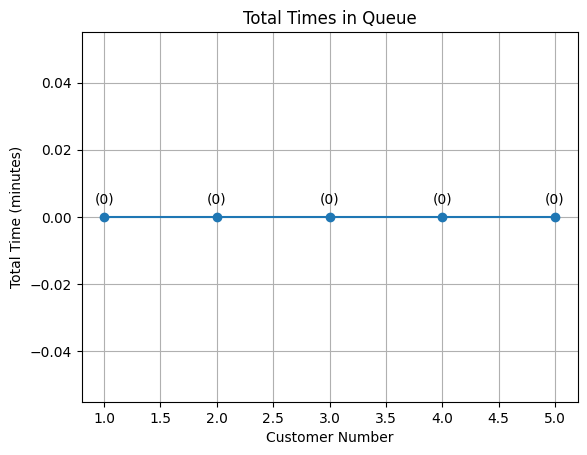

In [17]:
# Plotting Total Time each Complain Customer Spends in the Queue (W_Qn)
x = list(range(1,len(W_Q["complain"])+1))
# plt.figure(figsize=(15, 10))
plt.plot(x, W_Q["complain"], label="Total Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, W_Q["complain"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Times in Queue")
plt.xlabel("Customer Number")
plt.ylabel("Total Time (minutes)")
plt.show()


As mentioned above no customer has waited.
now considering interarrival times and service times, a single worker could have resulted this outcome.

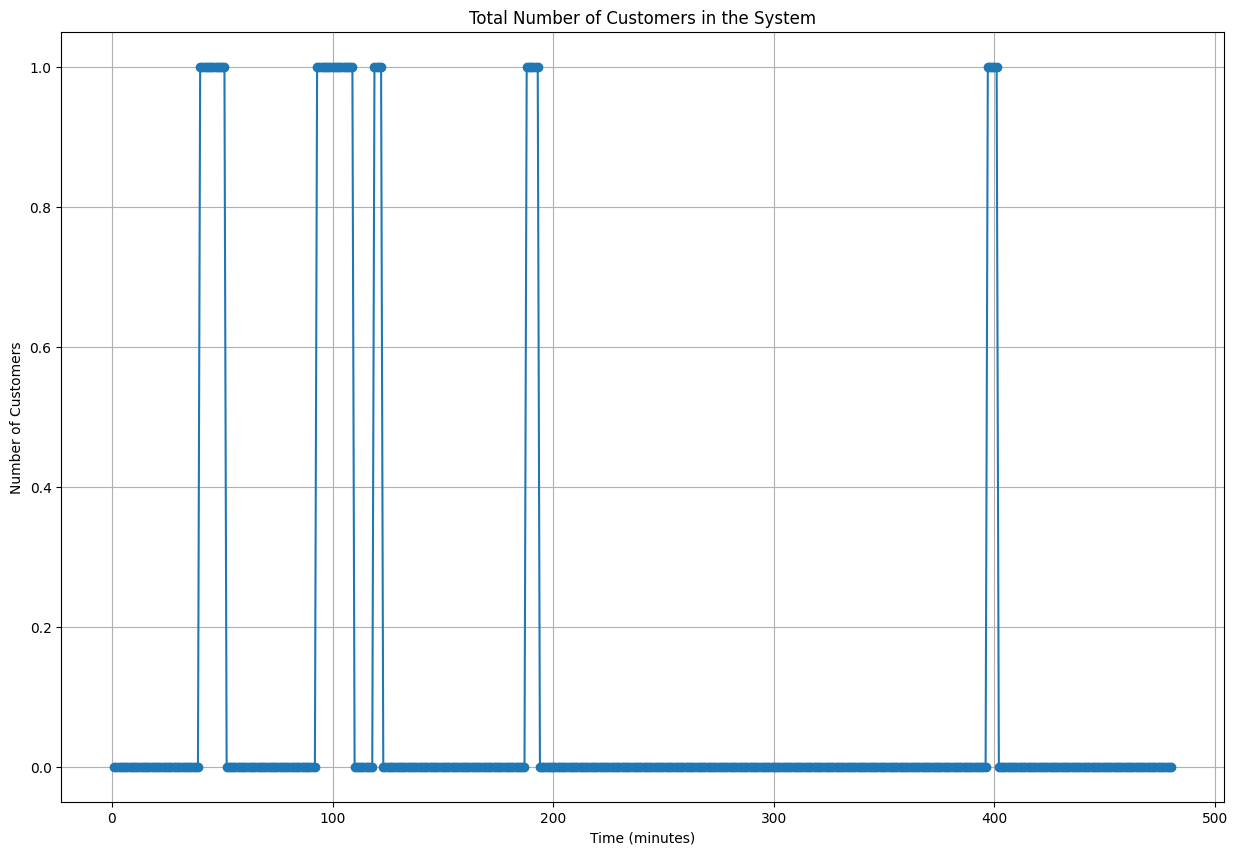

In [18]:
# Plotting Total Number of Customers in the System (L_n)
x = list(range(1,len(L["complain"])+1))
plt.figure(figsize=(15, 10))
plt.plot(x, L["complain"], label="Total Times", marker='o', linestyle='-')

# for i, (xi, yi) in enumerate(zip(x, L["complain"])):
    # plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Number of Customers in the System")
plt.xlabel("Time (minutes)")
plt.ylabel("Number of Customers")
plt.show()

As expected at most there is one customer in the system at every minute.
they arrive, recieve their service and leave the system

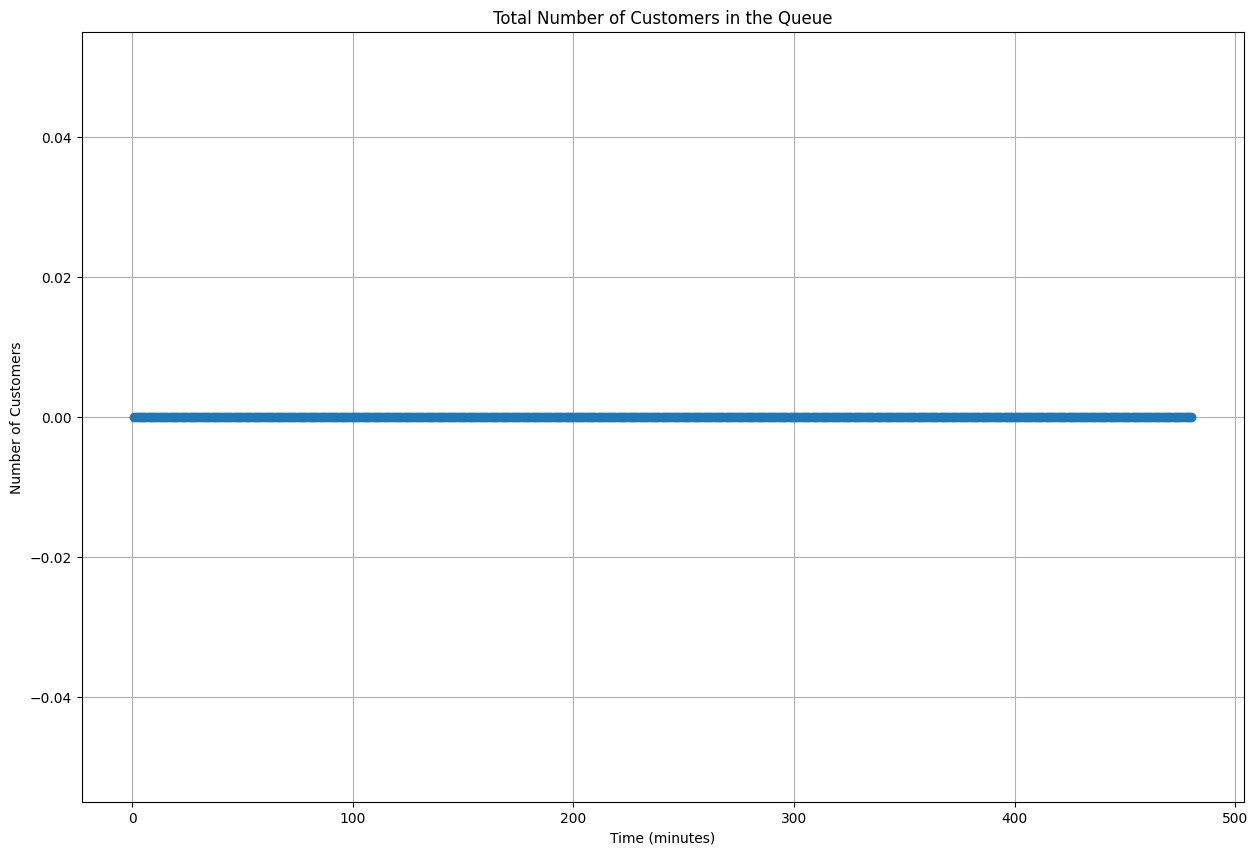

In [19]:
# Plotting Total Number of Customers in the Queue at Time n (L_Qn)
x = list(range(1,len(L_Q["complain"])+1))
plt.figure(figsize=(15, 10))
plt.plot(x, L_Q["complain"], label="Total Times", marker='o', linestyle='-')

# for i, (xi, yi) in enumerate(zip(x, L_Q["complain"])):
    # plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Number of Customers in the Queue")
plt.xlabel("Time (minutes)")
plt.ylabel("Number of Customers")
plt.show()

Queue never forms for this service.

In [20]:
# Calculate the average number of customers in the system(L) and in the queue(L_Q),
# and the average time spent in the system(W) and in the queue(W_Q) for each service type.

# Average Number of Customers in the System (L)
L_avg = np.mean(L["complain"])
print(f"Average Number of Customers in the System (L): {L_avg}")

# Average Number of Customers in the Queue (L_Q)
L_Q_avg = np.mean(L_Q["complain"])
print(f"Average Number of Customers in the Queue (L_Q): {L_Q_avg}")

# Average Time Spent in the System (W)
W_avg = np.mean(W["complain"])
print(f"Average Time Spent in the System (W): {W_avg}")

# Average Time Spent in the Queue (W_Q)
W_Q_avg = np.mean(W_Q["complain"])
print(f"Average Time Spent in the Queue (W_Q): {W_Q_avg}")

Average Number of Customers in the System (L): 0.09166666666666666
Average Number of Customers in the Queue (L_Q): 0.0
Average Time Spent in the System (W): 8.8
Average Time Spent in the Queue (W_Q): 0.0


# Confirm Service

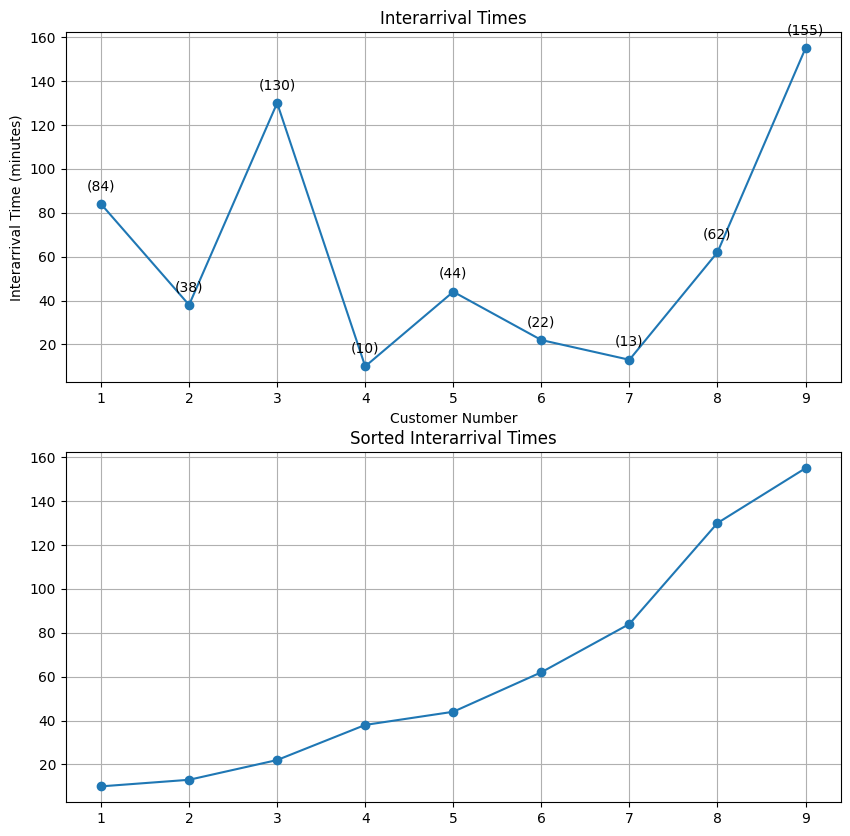

In [51]:
# Plotting Interarrival Times of Confirm Customers (A_n)
x = list(range(1,len(A["confirm"])+1))
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(x, A["confirm"], label="Interarrival Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, A["confirm"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Interarrival Times")
plt.xlabel("Customer Number")
plt.ylabel("Interarrival Time (minutes)")

plt.subplot(212)
draw_line_chart(x, A['confirm'], "Sorted Interarrival Times", sorted=True)

plt.show()


Here the interarrival times follow gamma ditribution(slides formula) with $E[x] = \frac{1}{\theta} = 60 $

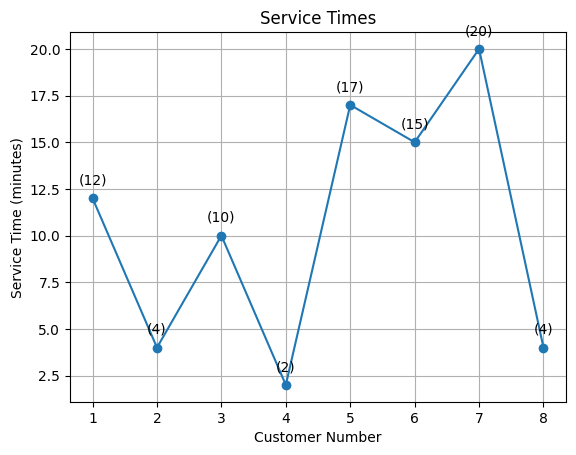

In [22]:
# Plotting Service Times of Confirm Customers (S_n)
x = list(range(1,len(S["confirm"])+1))
# plt.figure(figsize=(15, 10))
plt.plot(x, S["confirm"], label="Service Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, S["confirm"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Service Times")
plt.xlabel("Customer Number")
plt.ylabel("Service Time (minutes)")
plt.show()


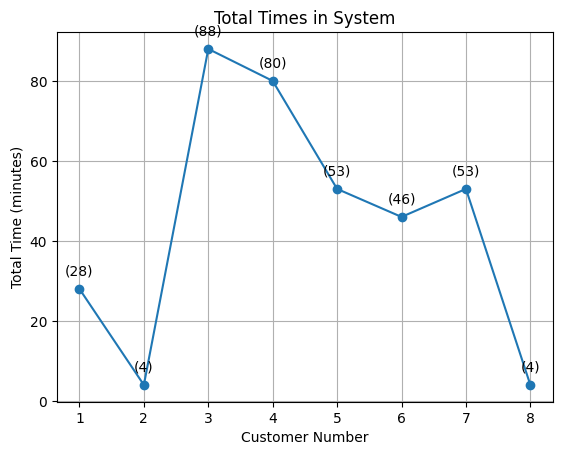

In [23]:
# Plotting Total Time each Confirm Customer Spends in the System (W_n)
x = list(range(1,len(W["confirm"])+1))
# plt.figure(figsize=(15, 10))
plt.plot(x, W["confirm"], label="Total Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, W["confirm"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Times in System")
plt.xlabel("Customer Number")
plt.ylabel("Total Time (minutes)")
plt.show()


Here considering the arrival intervals it appears that when customer 1 arrives there are no workers for this service job; the same is True for customer 3 and 4 which is why their time in the system is alot more than their service time.
but for customer 2 and 8 there is a free worker available when they arrive because their time in the system is equal to their service time.

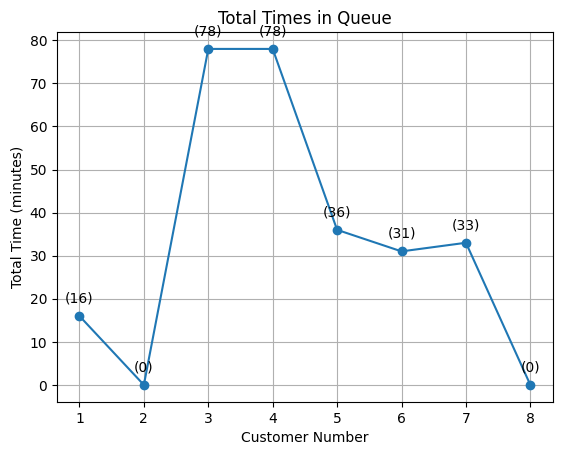

In [24]:
# Plotting Total Time each Confirm Customer Spends in the Queue (W_Qn)
x = list(range(1,len(W_Q["confirm"])+1))
# plt.figure(figsize=(15, 10))
plt.plot(x, W_Q["confirm"], label="Total Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, W_Q["confirm"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Times in Queue")
plt.xlabel("Customer Number")
plt.ylabel("Total Time (minutes)")
plt.show()

Here as explained above there is no waiting time for customer 2 and 8 but another interesting fact is that for customer 3 and 4 their waiting time is exactly equal which considering that customer 4 has arrived 10 minutes after customer 3 it implies that a second worker has changed his job to this series 10 minutes after the first one has 

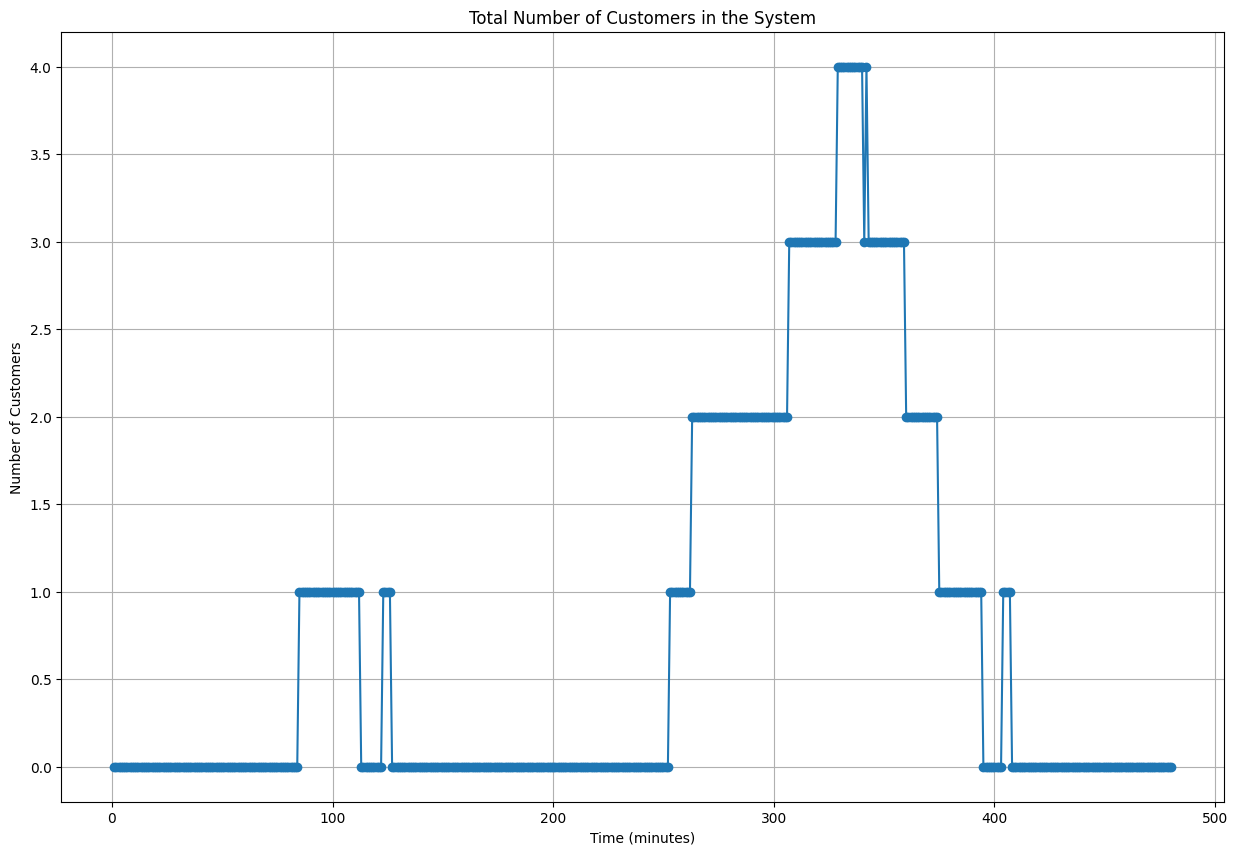

In [25]:
# Plotting Total Number of Customers in the System (L_n)
x = list(range(1,len(L["confirm"])+1))
plt.figure(figsize=(15, 10))
plt.plot(x, L["confirm"], label="Total Times", marker='o', linestyle='-')

# for i, (xi, yi) in enumerate(zip(x, L["confirm"])):
    # plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Number of Customers in the System")
plt.xlabel("Time (minutes)")
plt.ylabel("Number of Customers")
plt.show()



Here you can see  that's two short Peaks for customer 2 and 8 which  lasts only as  their respective service time.

 we can also see the huge peach that has been created because of a long time lack of workers in these job starting at the arrival time of customer 3.


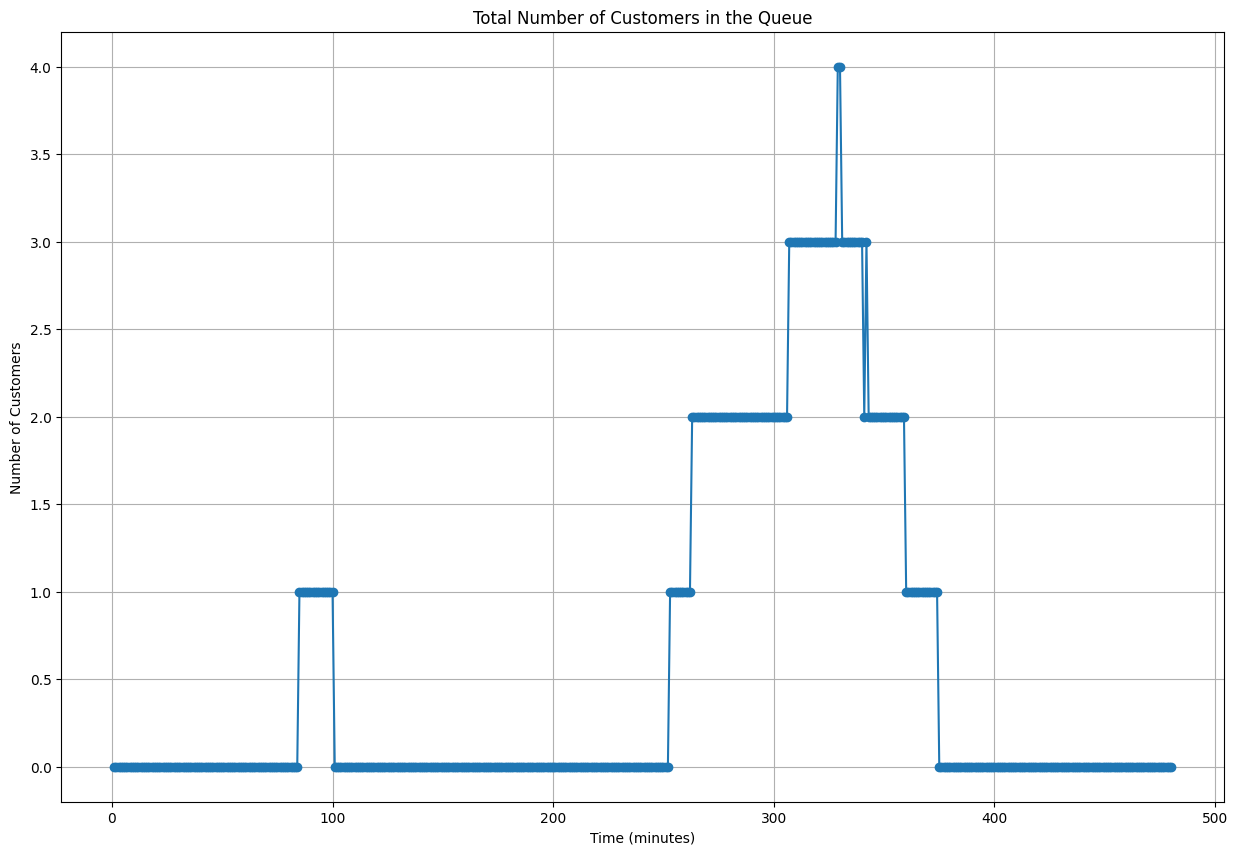

In [26]:
# Plotting Total Number of Customers in the Queue at Time n (L_Qn)
x = list(range(1,len(L_Q["confirm"])+1))
plt.figure(figsize=(15, 10))
plt.plot(x, L_Q["confirm"], label="Total Times", marker='o', linestyle='-')

# for i, (xi, yi) in enumerate(zip(x, L_Q["confirm"])):
    # plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Number of Customers in the Queue")
plt.xlabel("Time (minutes)")
plt.ylabel("Number of Customers")
plt.show()


Here as expected there are no Peaks for the arrival of customer 2 and 8.
We can also see that customer 3 has to wait Until the arrival of customer 6 to get service.

In [27]:
# Calculate the average number of customers in the system(L) and in the queue(L_Q),
# and the average time spent in the system(W) and in the queue(W_Q) for each service type.

# Average Number of Customers in the System (L)
L_avg = np.mean(L["confirm"])
print(f"Average Number of Customers in the System (L): {L_avg}")

# Average Number of Customers in the Queue (L_Q)
L_Q_avg = np.mean(L_Q["confirm"])
print(f"Average Number of Customers in the Queue (L_Q): {L_Q_avg}")

# Average Time Spent in the System (W)
W_avg = np.mean(W["confirm"])
print(f"Average Time Spent in the System (W): {W_avg}")

# Average Time Spent in the Queue (W_Q)
W_Q_avg = np.mean(W_Q["confirm"])
print(f"Average Time Spent in the Queue (W_Q): {W_Q_avg}")

Average Number of Customers in the System (L): 0.7416666666666667
Average Number of Customers in the Queue (L_Q): 0.5666666666666667
Average Time Spent in the System (W): 44.5
Average Time Spent in the Queue (W_Q): 34.0


# Request Service

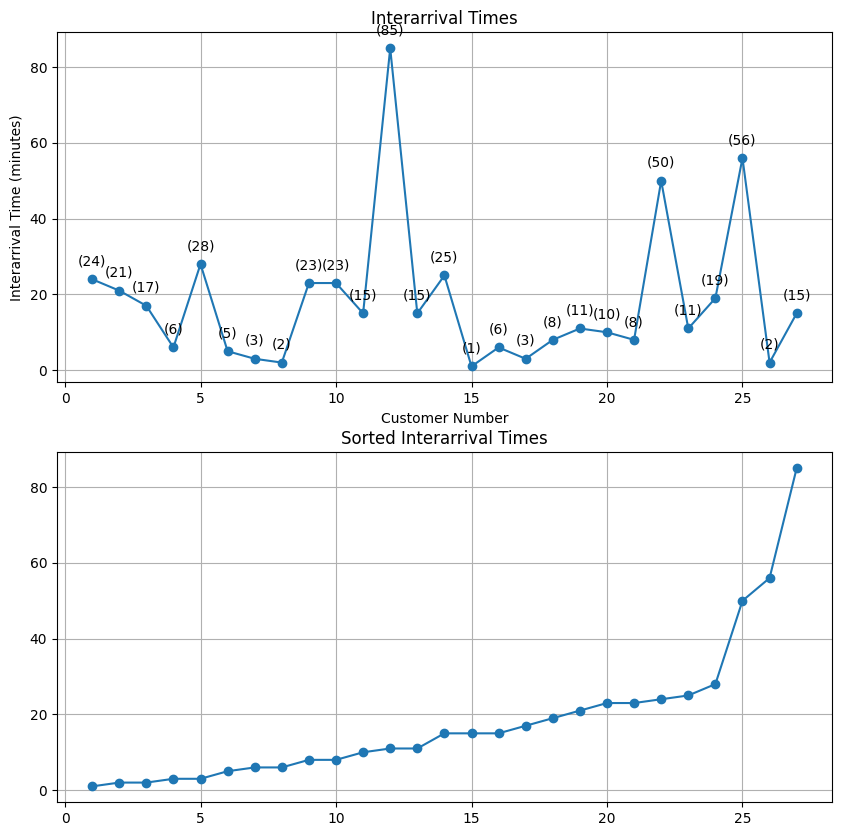

In [52]:
# Plotting Interarrival Times of Request Customers (A_n)
x = list(range(1,len(A["request"])+1))
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(x, A["request"], label="Interarrival Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, A["request"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Interarrival Times")
plt.xlabel("Customer Number")
plt.ylabel("Interarrival Time (minutes)")

plt.subplot(212)
draw_line_chart(x, A['request'], "Sorted Interarrival Times", sorted=True)

plt.show()


Here as expected the interarrival times follow exponential distribution with mean $ \frac{1}{0.06} = 16.67 $

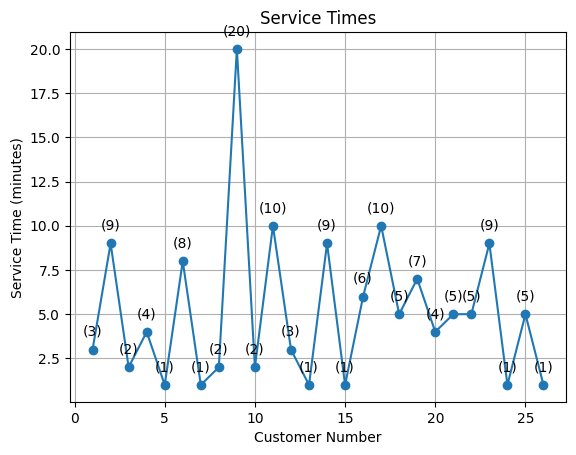

In [29]:
# Plotting Service Times of Request Customers (S_n)
x = list(range(1,len(S["request"])+1))
# plt.figure(figsize=(15, 10))
plt.plot(x, S["request"], label="Service Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, S["request"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Service Times")
plt.xlabel("Customer Number")
plt.ylabel("Service Time (minutes)")
plt.show()

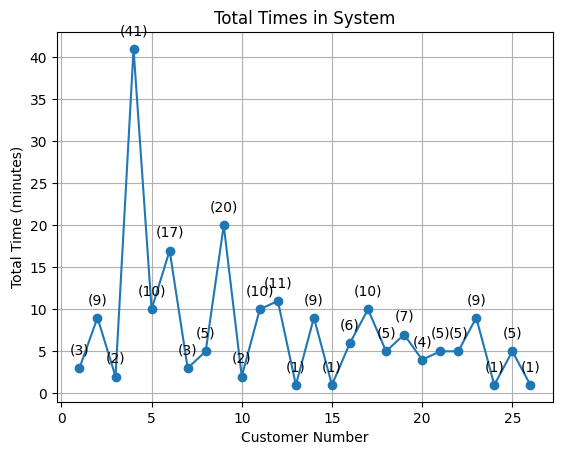

In [30]:
# Plotting Total Time each Request Customer Spends in the System (W_n)
x = list(range(1,len(W["request"])+1))
# plt.figure(figsize=(15, 10))
plt.plot(x, W["request"], label="Total Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, W["request"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Times in System")
plt.xlabel("Customer Number")
plt.ylabel("Total Time (minutes)")
plt.show()


Hear the similarity of the shape and values in this graph to the "Service Time" graph, particularly after customer number 10, implies that there are no long waiting time in queue for them and for many no waiting time at all.

But also the peak for customer number four implies that it has weighted relatively long time in a queue.


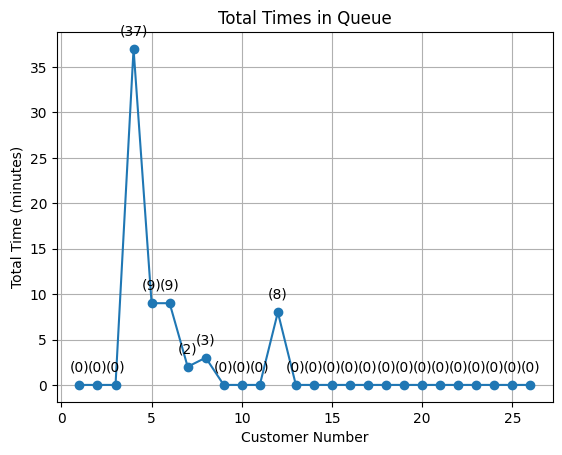

In [31]:
# Plotting Total Time each Request Customer Spends in the Queue (W_Qn)
x = list(range(1,len(W_Q["request"])+1))
# plt.figure(figsize=(15, 10))
plt.plot(x, W_Q["request"], label="Total Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, W_Q["request"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Times in Queue")
plt.xlabel("Customer Number")
plt.ylabel("Total Time (minutes)")
plt.show()

As expected and stated above most customers do not wait in queue at all and customer number four has a very long waiting time 

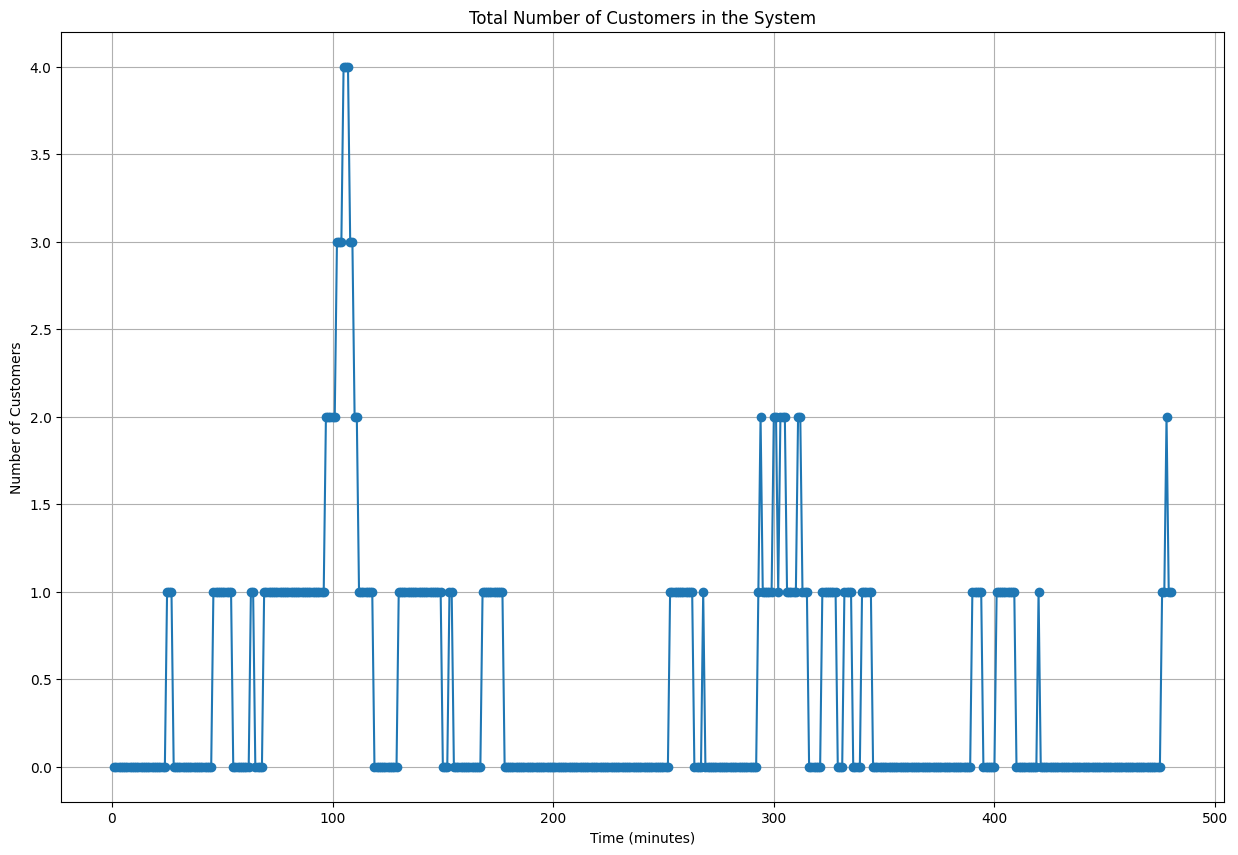

In [32]:
# Plotting Total Number of Customers in the System (L_n)
x = list(range(1,len(L["request"])+1))
plt.figure(figsize=(15, 10))
plt.plot(x, L["request"], label="Total Times", marker='o', linestyle='-')

# for i, (xi, yi) in enumerate(zip(x, L["request"])):
    # plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Number of Customers in the System")
plt.xlabel("Time (minutes)")
plt.ylabel("Number of Customers")
plt.show()


Here we can understand that the reason for a long waiting time of customer 4 is the lack of workers in this field when that customer arrives because before that there was no customers in the system so there could not be any busy workers

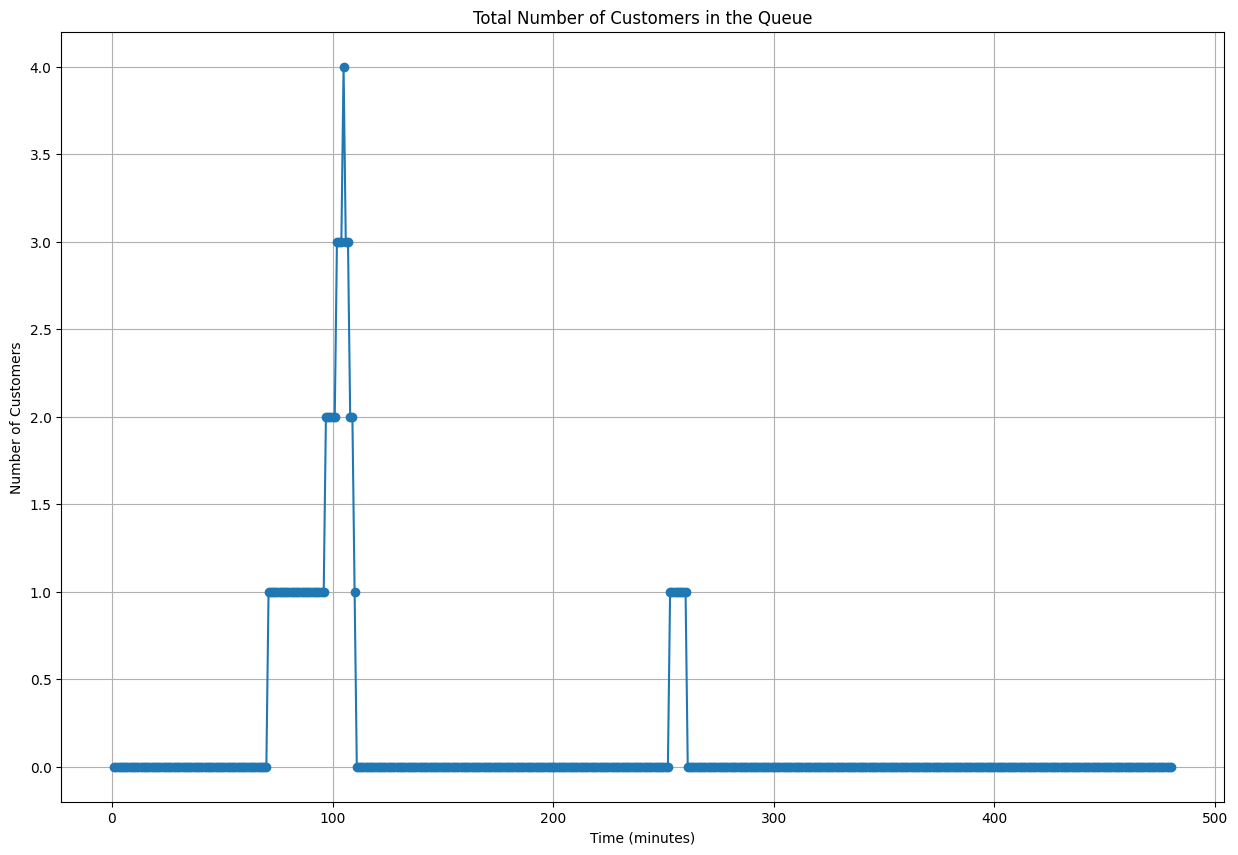

In [33]:
# Plotting Total Number of Customers in the Queue at Time n (L_Qn)
x = list(range(1,len(L_Q["request"])+1))
plt.figure(figsize=(15, 10))
plt.plot(x, L_Q["request"], label="Total Times", marker='o', linestyle='-')

# for i, (xi, yi) in enumerate(zip(x, L_Q["request"])):
    # plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Number of Customers in the Queue")
plt.xlabel("Time (minutes)")
plt.ylabel("Number of Customers")
plt.show()


In [34]:
# Calculate the average number of customers in the system(L) and in the queue(L_Q),
# and the average time spent in the system(W) and in the queue(W_Q) for each service type.

# Average Number of Customers in the System (L)
L_avg = np.mean(L["request"])
print(f"Average Number of Customers in the System (L): {L_avg}")

# Average Number of Customers in the Queue (L_Q)
L_Q_avg = np.mean(L_Q["request"])
print(f"Average Number of Customers in the Queue (L_Q): {L_Q_avg}")

# Average Time Spent in the System (W)
W_avg = np.mean(W["request"])
print(f"Average Time Spent in the System (W): {W_avg}")

# Average Time Spent in the Queue (W_Q)
W_Q_avg = np.mean(W_Q["request"])
print(f"Average Time Spent in the Queue (W_Q): {W_Q_avg}")

Average Number of Customers in the System (L): 0.42083333333333334
Average Number of Customers in the Queue (L_Q): 0.14166666666666666
Average Time Spent in the System (W): 7.769230769230769
Average Time Spent in the Queue (W_Q): 2.6153846153846154


# Review Service

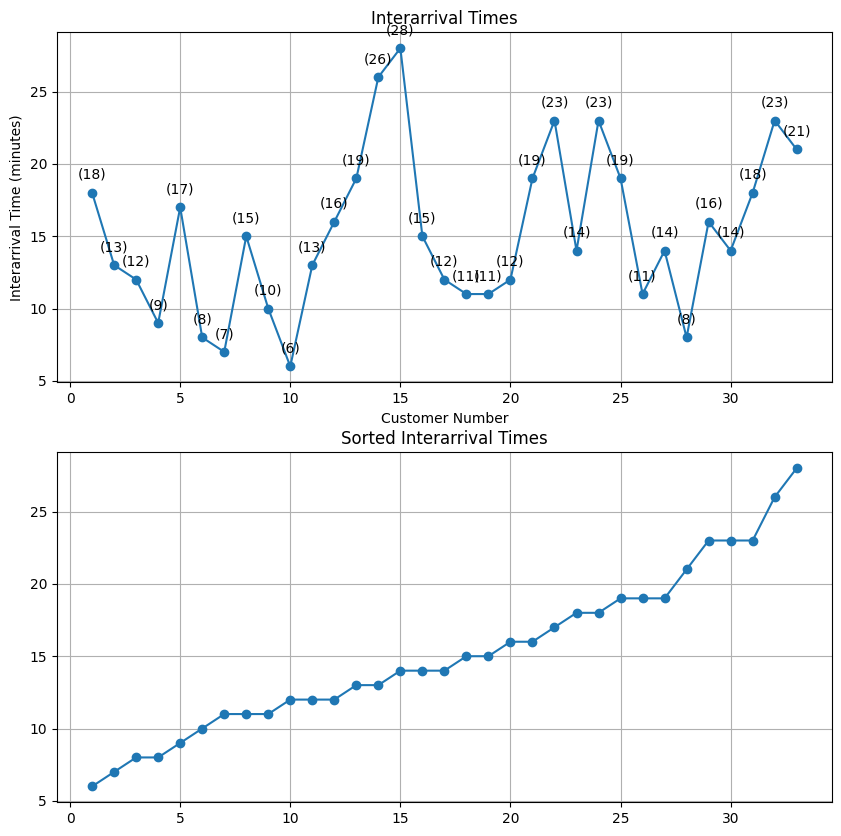

In [53]:
# Plotting Interarrival Times of Review Customers (A_n)
x = list(range(1,len(A["review"])+1))
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(x, A["review"], label="Interarrival Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, A["review"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Interarrival Times")
plt.xlabel("Customer Number")
plt.ylabel("Interarrival Time (minutes)")

plt.subplot(212)
draw_line_chart(x, A['review'], "Sorted Interarrival Times", sorted=True)

plt.show()


The Arrival intervals follow normal distribution with minimum value 15 minutes, as it can be seen from the graph.

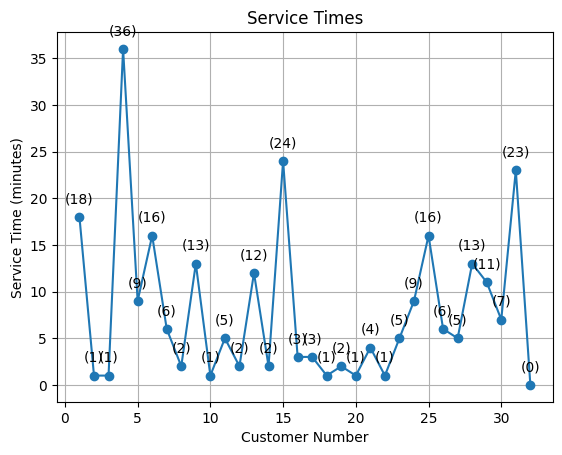

In [36]:
# Plotting Service Times of Review Customers (S_n)
x = list(range(1,len(S["review"])+1))
# plt.figure(figsize=(15, 10))
plt.plot(x, S["review"], label="Service Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, S["review"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Service Times")
plt.xlabel("Customer Number")
plt.ylabel("Service Time (minutes)")
plt.show()


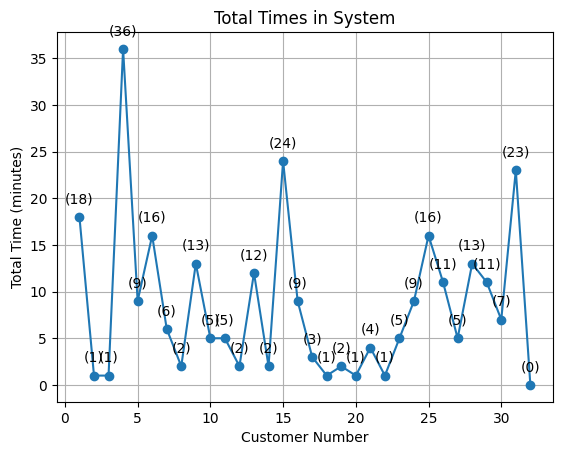

In [37]:
# Plotting Total Time each Review Customer Spends in the System (W_n)
x = list(range(1,len(W["review"])+1))
# plt.figure(figsize=(15, 10))
plt.plot(x, W["review"], label="Total Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, W["review"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Times in System")
plt.xlabel("Customer Number")
plt.ylabel("Total Time (minutes)")
plt.show()


here the graph for total time in the system is very similar in shape to the service time graph and hence we can deduce that for most customers there shouldn't be much waiting time 


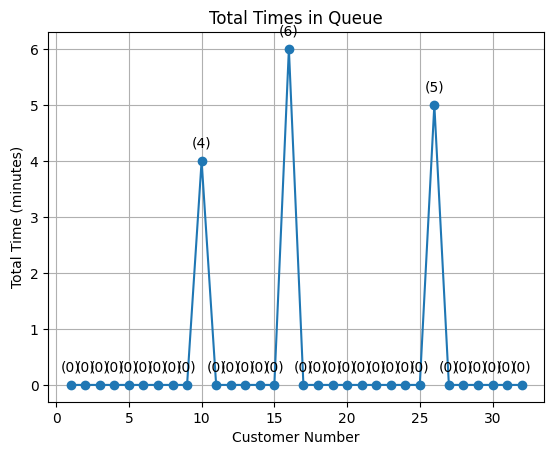

In [38]:
# Plotting Total Time each Review Customer Spends in the Queue (W_Qn)
x = list(range(1,len(W_Q["review"])+1))
# plt.figure(figsize=(15, 10))
plt.plot(x, W_Q["review"], label="Total Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, W_Q["review"])):
    plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Times in Queue")
plt.xlabel("Customer Number")
plt.ylabel("Total Time (minutes)")
plt.show()

I was expected there is not a lot of waiting times for customers in this service which considering the clothes inter arrival times and  almost the same duration for service times it employs that there are enough workers in this service 

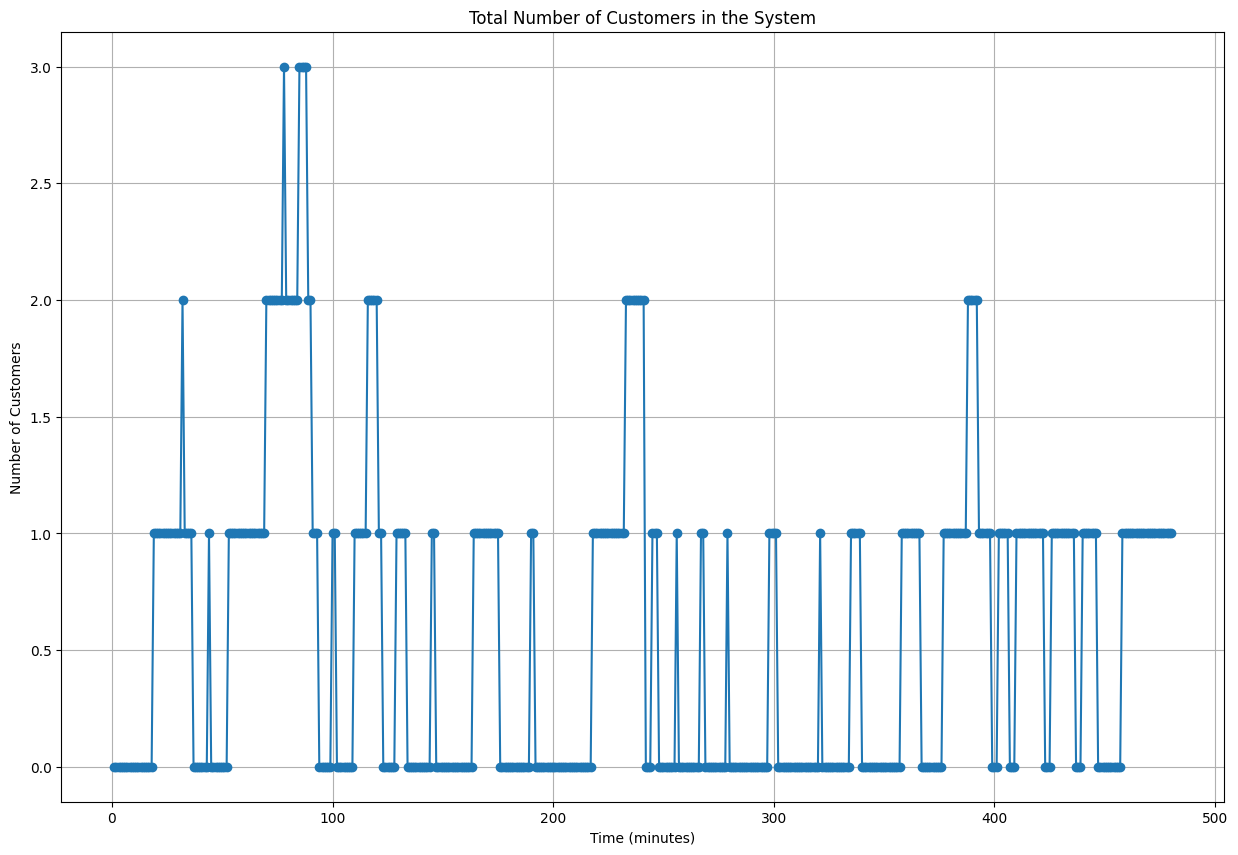

In [39]:
# Plotting Total Number of Customers in the System (L_n)
x = list(range(1,len(L["review"])+1))
plt.figure(figsize=(15, 10))
plt.plot(x, L["review"], label="Total Times", marker='o', linestyle='-')

# for i, (xi, yi) in enumerate(zip(x, L["review"])):
    # plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Number of Customers in the System")
plt.xlabel("Time (minutes)")
plt.ylabel("Number of Customers")
plt.show()

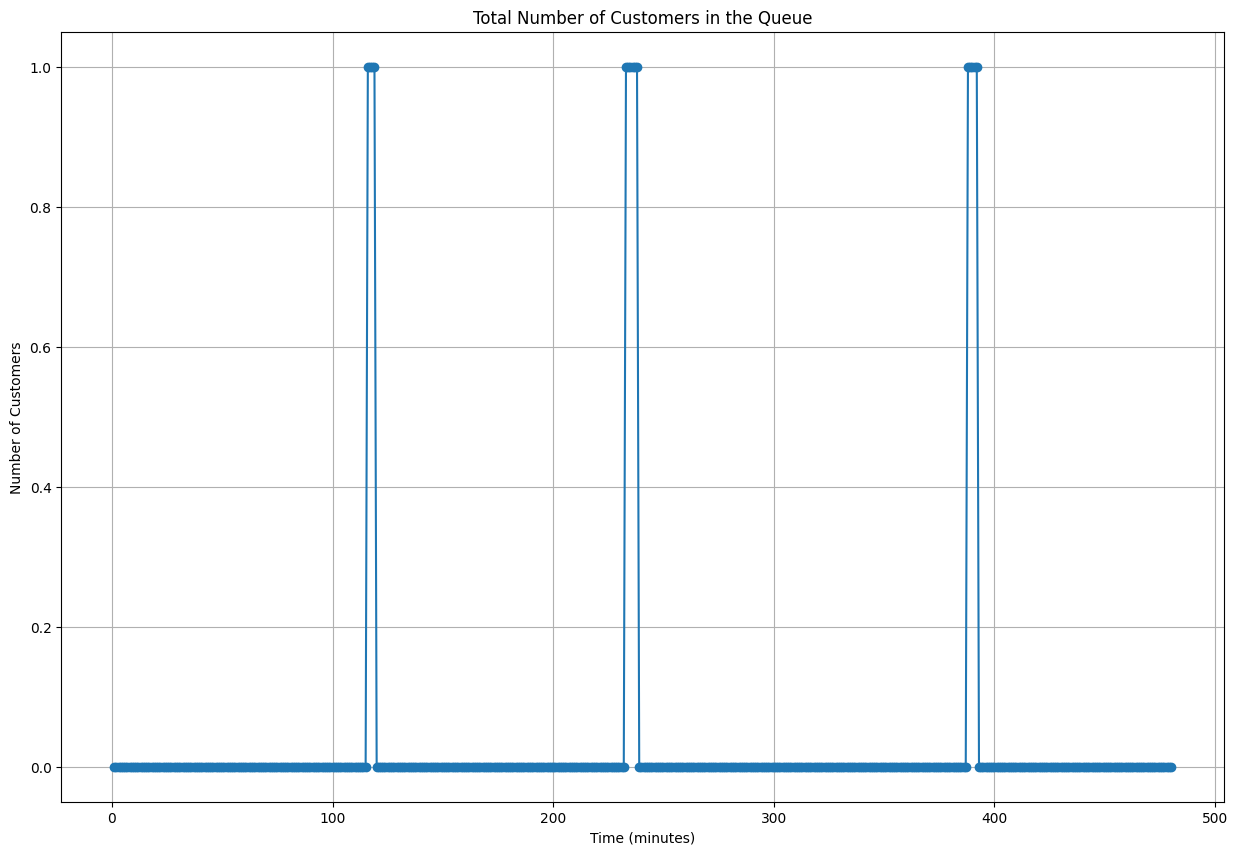

In [40]:
# Plotting Total Number of Customers in the Queue at Time n (L_Qn)
x = list(range(1,len(L_Q["review"])+1))
plt.figure(figsize=(15, 10))
plt.plot(x, L_Q["review"], label="Total Times", marker='o', linestyle='-')

# for i, (xi, yi) in enumerate(zip(x, L_Q["review"])):
    # plt.annotate(f'({yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Number of Customers in the Queue")
plt.xlabel("Time (minutes)")
plt.ylabel("Number of Customers")
plt.show()


I considering two graphs above we are certain that at times there are more than two worker in this service because there are three customers in the system and no customers in the queue 

In [41]:
# Calculate the average number of customers in the system(L) and in the queue(L_Q),
# and the average time spent in the system(W) and in the queue(W_Q) for each service type.

# Average Number of Customers in the System (L)
L_avg = np.mean(L["review"])
print(f"Average Number of Customers in the System (L): {L_avg}")

# Average Number of Customers in the Queue (L_Q)
L_Q_avg = np.mean(L_Q["review"])
print(f"Average Number of Customers in the Queue (L_Q): {L_Q_avg}")

# Average Time Spent in the System (W)
W_avg = np.mean(W["review"])
print(f"Average Time Spent in the System (W): {W_avg}")

# Average Time Spent in the Queue (W_Q)
W_Q_avg = np.mean(W_Q["review"])
print(f"Average Time Spent in the Queue (W_Q): {W_Q_avg}")

Average Number of Customers in the System (L): 0.56875
Average Number of Customers in the Queue (L_Q): 0.03125
Average Time Spent in the System (W): 8.53125
Average Time Spent in the Queue (W_Q): 0.46875


## Worker's Time Pie Chart

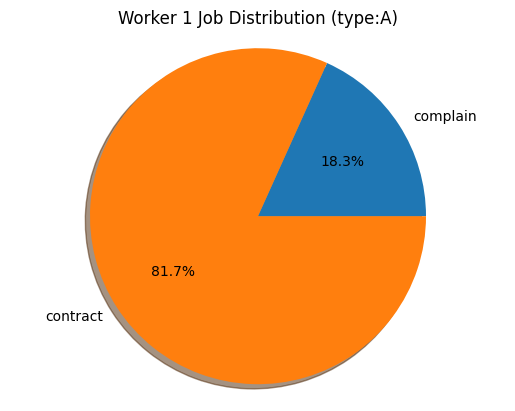

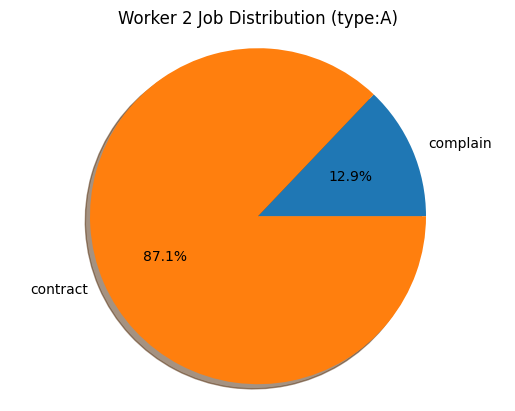

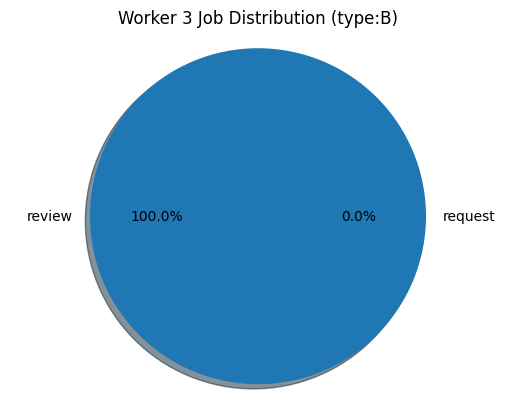

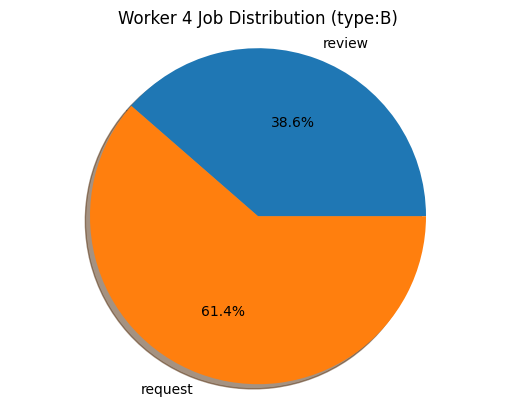

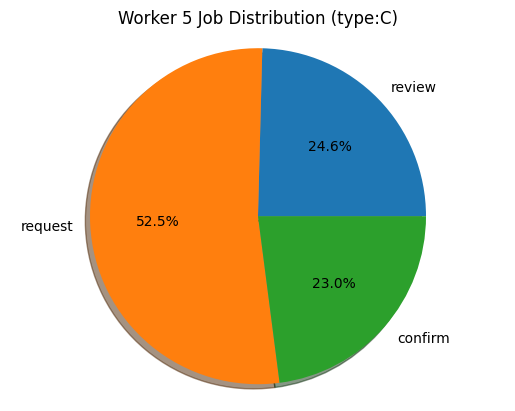

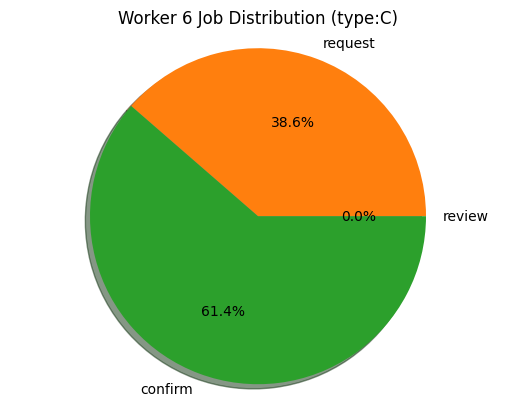

In [42]:
# draw pie chart for each worker of how much time they spent on each job
for i in range(len(workers_times)):
    worker = workers_times[i]
    labels = list(worker.keys())
    sizes = list(worker.values())
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
    ax1.axis('equal')
    plt.title(f"Worker {i+1} Job Distribution (type:{workers[i].type.name})")
    plt.show()